In [2]:
import xarray as xr
import numpy as np
import numpy as np
import xarray as xr
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from plots import map_plots

In [3]:
import os
import xarray as xr
import pandas as pd


def open_with_cftime(file_path, engine="netcdf4"):
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(
        file_path,
        engine=engine,
        decode_times=time_coder
    )
    iso_times = ds['time'].dt.strftime('%Y-%m-%dT%H:%M:%S').values
    pd_times = pd.to_datetime(iso_times)
    return ds.assign_coords(time=pd_times)

In [4]:
def compute_weekly_climatology(file_list, variable=None):
    datasets = [open_with_cftime(fp) for fp in file_list if os.path.isfile(fp)]
    combined = xr.concat(datasets, dim='time', data_vars='minimal', coords='minimal')
    da = combined[variable] if variable else combined
    daily = da.resample(time='1D').sum(dim='time')
    daily = daily.assign_coords(weekofyear=daily['time'].dt.isocalendar().week)
    weekly_clim = daily.groupby('weekofyear').median(dim='time')
    # Sample 1 year
    #df = daily.to_dataframe().reset_index()
    #df['week'] = df['time'].dt.isocalendar().week
    #df['year'] = df['time'].dt.year
    #df['iso_year'] = df['time'].dt.isocalendar().year
    #df['dayofyear'] = df['time'].dt.dayofyear
    # Group and print
    #for week in sorted(df['week'].unique()):
        #sample = df[df['week'] == week]
        #print(f"Week {week:02d}: {sample['time'].min().date()} to {sample['time'].max().date()} ({len(sample)} days)")

    return weekly_clim, daily

In [5]:
diri = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/"
models = [
    "ACCESS-CM2", "CanESM5", "CMCC-CM2-SR5", "CMCC-ESM2",
    "HadGEM3-GC31-LL", "HadGEM3-GC31-MM", "MRI-ESM2-0"
]
variable_name = "specific generation"

# Define periods and years
periods = {
    "BOC": {"subpath": "historical", "years": list(range(1980, 2015))},
    "EOC": {"subpath": "ssp585",    "years": list(range(2065, 2100))}
}

In [6]:
for model in models:
    for period, info in periods.items():
        base_dir = os.path.join(diri, f"{model}_1x1grid", info['subpath'])

        # Prepare file list for the whole period
        files = [os.path.join(base_dir, f"solar_power_{yr}.nc") for yr in info['years']]
        print(files)

        # Define output path
        output_dir = base_dir
        os.makedirs(output_dir, exist_ok=True)

        # Save weekly climatology
        filename = "daily_mean_per_week.nc"
        output_path = os.path.join(output_dir, filename)
        
        weekly_clim, daily = compute_weekly_climatology(files, variable=variable_name)

        if not os.path.isfile(output_path):
            weekly_clim.to_netcdf(output_path)
            print(f"Saved weekly climatology for {model} - {period}: {output_path}")
        else:
            print(f"File already exists, skipping weekly climatology: {output_path}")

        # Save daily time series by year
        for yr in info['years']:
            # Select only the data from the current year
            daily_year = daily.sel(time=str(yr))
            daily_output_path = os.path.join(output_dir, f"daily_solar_power_{yr}.nc")

            if not os.path.isfile(daily_output_path):
                daily_year.to_netcdf(daily_output_path)
                print(f"Saved daily solar power for {model} - {period} - {yr}: {daily_output_path}")
            else:
                print(f"File already exists, skipping daily data: {daily_output_path}")


['/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/ACCESS-CM2_1x1grid/historical/solar_power_1980.nc', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/ACCESS-CM2_1x1grid/historical/solar_power_1981.nc', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/ACCESS-CM2_1x1grid/historical/solar_power_1982.nc', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/ACCESS-CM2_1x1grid/historical/solar_power_1983.nc', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/ACCESS-CM2_1x1grid/historical/solar_power_1984.nc', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/ACCESS-CM2_1x1grid/historical/solar_power_1985.nc', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/ACCESS-CM2_1x1grid/historical/solar_power_1986.nc', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Gen

In [7]:
base_dir_era5 = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power_Era5_h_1x1/"
# Prepare file list for the whole period
years=list(range(1980, 2015))
files_era5 = [os.path.join(base_dir_era5, f"hourly_power_era5_{yr}.nc") for yr in years]
print(files_era5)
print(f"Existing files: {[fp for fp in files_era5 if os.path.isfile(fp)]}")
for file in files_era5:
    output_dir=base_dir_era5
    filename= "daily_mean_per_week.nc"
    output_path = os.path.join(output_dir, filename)
    weekly_clim_era5, daily_era5= compute_weekly_climatology(files_era5, variable=variable_name)

    if not os.path.isfile(output_path):
            weekly_clim_era5.to_netcdf(output_path)
            print(f"Saved weekly climatology for era5: {output_path}")
    else:
        print(f"File already exists, skipping weekly climatology: {output_path}")

    # Save daily time series by year
    for yr in years:
        # Select only the data from the current year
        daily_year = daily_era5.sel(time=str(yr))
        daily_output_path = os.path.join(output_dir, f"daily_solar_power_{yr}.nc")

        if not os.path.isfile(daily_output_path):
            daily_year.to_netcdf(daily_output_path)
            print(f"Saved daily solar power for era5: {daily_output_path}")
        else:
            print(f"File already exists, skipping daily data: {daily_output_path}")


['/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power_Era5_h_1x1/hourly_power_era5_1980.nc', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power_Era5_h_1x1/hourly_power_era5_1981.nc', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power_Era5_h_1x1/hourly_power_era5_1982.nc', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power_Era5_h_1x1/hourly_power_era5_1983.nc', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power_Era5_h_1x1/hourly_power_era5_1984.nc', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power_Era5_h_1x1/hourly_power_era5_1985.nc', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power_Era5_h_1x1/hourly_power_era5_1986.nc', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power_Era5_h_1x1/hourly_power_era5_1987.nc', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power_Era5_h_1x1/h

In [8]:
diri = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation.backup/power/"
models = [
    "ACCESS-CM2", "CanESM5", "CMCC-CM2-SR5", "CMCC-ESM2",
    "HadGEM3-GC31-LL", "HadGEM3-GC31-MM", "MRI-ESM2-0"
]
variable_name = "specific generation"

# Define periods and years
periods = {
    "BOC": {"subpath": "historical", "years": list(range(1980, 2015))},
    "EOC": {"subpath": "ssp585",    "years": list(range(2065, 2100))}
}

In [23]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from itertools import groupby

def extract_events(series):
    """
    Return a list of (start_index, length) for each run of True in the 1D boolean array.
    """
    events = []
    in_event = False
    for idx, val in enumerate(series):
        if val and not in_event:
            in_event = True
            start_idx = idx
            length = 1
        elif val and in_event:
            length += 1
        elif not val and in_event:
            events.append((start_idx, length))
            in_event = False
    if in_event:
        events.append((start_idx, length))
    return events

models = [
    "ACCESS-CM2", "CanESM5", "CMCC-CM2-SR5", "CMCC-ESM2",
    "HadGEM3-GC31-LL", "HadGEM3-GC31-MM", "MRI-ESM2-0"
]
periods = {
    "BOC": {"subpath": "historical", "years": list(range(1980, 2015))},
    "EOC": {"subpath": "ssp585",    "years": list(range(2065, 2100))}
}
diri = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power"

# define duration bins for later plotting
dur_bins   = [0, 1, 3, 5, 7, np.inf]
dur_labels = ["0-1","1-3","3-5","5-7",">7"]

for model in models:
    for period, info in periods.items():
        all_events = []

        base_dir  = os.path.join(diri, f"{model}_1x1grid", info["subpath"])
        clim_file = os.path.join(base_dir, "daily_mean_per_week.nc")
        weekly_clim = xr.open_dataset(clim_file)["specific generation"]
        threshold   = weekly_clim * 0.5

        # read coords from a sample year
        sample = xr.open_dataset(
            os.path.join(base_dir, f"daily_solar_power_{info['years'][0]}.nc")
        )["specific generation"]
        lats = sample["lat"].values   # (ny,)
        lons = sample["lon"].values   # (nx,)

        for yr in info["years"]:
            ds = xr.open_dataset(os.path.join(base_dir, f"daily_solar_power_{yr}.nc"))
            daily = ds["specific generation"]
            daily = daily.assign_coords(weekofyear=daily.time.dt.isocalendar().week)

            is_drought = daily < threshold.sel(weekofyear=daily.weekofyear)
            mask       = is_drought.values     # (time, ny, nx)
            times      = daily.time.values     # (time,)
            nt, ny, nx = mask.shape

            seasons = {
                "Winter": [12,1,2],
                "Spring": [3,4,5],
                "Summer": [6,7,8],
                "Autumn": [9,10,11]
            }
            for season_name, months in seasons.items():
                month_idx    = daily.time.dt.month.isin(months).values
                season_mask  = mask[month_idx,:,:]    # (t_season,ny,nx)
                season_times = times[month_idx]

                for y in range(ny):
                    for x in range(nx):
                        for start_idx, length in extract_events(season_mask[:,y,x]):
                            if length >= 1:  # or >=2
                                start_time  = season_times[start_idx]
                                start_month = int(pd.to_datetime(start_time).month)
                                all_events.append({
                                    "model":       model,
                                    "period":      period,
                                    "year":        yr,
                                    "season":      season_name,
                                    "lat":         float(lats[y]),
                                    "lon":         float(lons[x]),
                                    "start_month": start_month,
                                    "duration":    int(length),
                                })

        # convert to DataFrame and assign duration bins
        df = pd.DataFrame(all_events)
        df["dur_bin"] = pd.cut(df.duration, bins=dur_bins, labels=dur_labels)

        # write one CSV per model⋅period
        out_csv = os.path.join(base_dir, f"solar_drought_events_{period}.csv")
        df.to_csv(out_csv, index=False)
        print(f"✅ Wrote {len(df)} events for {model}–{period} → {out_csv}")



✅ Wrote 1694351 events for ACCESS-CM2–BOC → /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/historical/solar_drought_events_BOC.csv
✅ Wrote 1579609 events for ACCESS-CM2–EOC → /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/ssp585/solar_drought_events_EOC.csv
✅ Wrote 1838975 events for CanESM5–BOC → /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/CanESM5_1x1grid/historical/solar_drought_events_BOC.csv
✅ Wrote 1594460 events for CanESM5–EOC → /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/CanESM5_1x1grid/ssp585/solar_drought_events_EOC.csv
✅ Wrote 2811897 events for CMCC-CM2-SR5–BOC → /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/CMCC-CM2-SR5_1x1grid/historical/solar_drought_events_BOC.csv
✅ Wrote 2600600 events for CMCC-CM2-SR5–EOC → /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/CMCC-CM2-SR

In [81]:
all_events = []
years = list(range(1980, 2015))
base_dir  = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power_Era5_h_1x1/"
clim_file = os.path.join(base_dir, "daily_mean_per_week.nc")
weekly_clim = xr.open_dataset(clim_file)["specific generation"]
threshold   = weekly_clim * 0.5
# define duration bins for later plotting
dur_bins   = [0, 1, 3, 5, 7, np.inf]
dur_labels = ["0-1","1-3","3-5","5-7",">7"]

# read coords from a sample year
sample = xr.open_dataset(
os.path.join(base_dir, f"daily_solar_power_2014.nc")
)["specific generation"]
lats = sample["lat"].values   # (ny,)
lons = sample["lon"].values   # (nx,)

for yr in years:
    ds = xr.open_dataset(os.path.join(base_dir, f"daily_solar_power_{yr}.nc"))
    daily = ds["specific generation"]
    daily = daily.assign_coords(weekofyear=daily.time.dt.isocalendar().week)

    is_drought = daily < threshold.sel(weekofyear=daily.weekofyear)
    mask       = is_drought.values     # (time, ny, nx)
    times      = daily.time.values     # (time,)
    nt, ny, nx = mask.shape

    seasons = {
        "Winter": [12,1,2],
        "Spring": [3,4,5],
        "Summer": [6,7,8],
        "Autumn": [9,10,11]
    }
    for season_name, months in seasons.items():
        month_idx    = daily.time.dt.month.isin(months).values
        season_mask  = mask[month_idx,:,:]    # (t_season,ny,nx)
        season_times = times[month_idx]

        for y in range(ny):
            for x in range(nx):
                for start_idx, length in extract_events(season_mask[:,y,x]):
                    if length >= 1:  # or >=2
                        start_time  = season_times[start_idx]
                        start_month = int(pd.to_datetime(start_time).month)
                        all_events.append({
                            "year":        yr,
                            "season":      season_name,
                            "lat":         float(lats[y]),
                            "lon":         float(lons[x]),
                            "start_month": start_month,
                            "duration":    int(length),
                        })

# convert to DataFrame and assign duration bins
df = pd.DataFrame(all_events)
df["dur_bin"] = pd.cut(df.duration, bins=dur_bins, labels=dur_labels)

# write one CSV per model⋅period
out_csv = os.path.join(base_dir, f"solar_drought_events.csv")
df.to_csv(out_csv, index=False)
print(f"✅ Wrote {len(df)} events for era5 → {out_csv}")


✅ Wrote 1635793 events for era5 → /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power_Era5_h_1x1/solar_drought_events.csv


In [9]:
import os
import numpy as np
import pandas as pd
import xarray as xr

# ————— SETTINGS —————
diri = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power"
models = [
    "ACCESS-CM2", "CanESM5", "CMCC-CM2-SR5", "CMCC-ESM2",
    "HadGEM3-GC31-LL", "HadGEM3-GC31-MM", "MRI-ESM2-0"
]
periods = {
    "BOC": "historical",
    "EOC": "ssp585"
}
quantiles = [0.50, 0.75, 0.90, 0.95]  # include 95th if desired
seasons = ["Winter", "Spring", "Summer", "Autumn"]
dur_bins = [0, 1, 3, 5, 7, np.inf]
dur_labels = ["0-1", "1-3", "3-5", "5-7", ">7"]

# ————— PROCESS —————
for model in models:
    for code, subpath in periods.items():
        base_dir = os.path.join(diri, f"{model}_1x1grid", subpath)
        csv_path = os.path.join(
            base_dir,
            f"solar_drought_events_{code}.csv"
        )
        if not os.path.isfile(csv_path):
            print(f"⚠️ Missing CSV for {model}-{code}, skipping.")
            continue

        # 1) Load the events table
        df = pd.read_csv(csv_path)

        # 2) Basic coords and normalization
        lats = np.sort(df["lat"].unique())
        lons = np.sort(df["lon"].unique())
        n_years = df["year"].nunique()

        # 3) Annual metrics

        # 3a) Total drought days over the full period
        total_dd = df.groupby(["lat","lon"])["duration"].sum()

        # 3b) Median annual drought days
        yearly = df.groupby(["lat","lon","year"])["duration"].sum()
        med_annual_dd = yearly.groupby(["lat","lon"]).median()

        # 3c) Event-duration percentiles over all events
        q = df.groupby(["lat","lon"])["duration"].quantile(quantiles)
        q = q.unstack(level=-1)
        q.columns = [f"p{int(q*100)}_dur" for q in quantiles]

        # 4) Seasonal metrics via DataArray.from_series

        # 4a) Total drought days per season
        ser_total_s = df.groupby(["lat","season","lon"])["duration"].sum()
        da_total_dd_season = xr.DataArray.from_series(ser_total_s)

        # 4b) Median annual drought days per season
        yearly_s = df.groupby(["lat","season","lon","year"])["duration"].sum()
        ser_med_ann_s = yearly_s.groupby(["lat","season","lon"]).median()
        da_med_annual_dd_season = xr.DataArray.from_series(ser_med_ann_s)

        # 4c) Event-duration percentiles per season
        ser_qs = df.groupby(["lat","season","lon"])["duration"].quantile(quantiles)
        ser_qs = ser_qs.unstack(level=-1)
        ser_qs.columns = [f"p{int(q*100)}_dur" for q in quantiles]
        da_seasonal = {
            col: xr.DataArray.from_series(ser_qs[col])
            for col in ser_qs.columns
        }

        # 5) Monthly counts by duration bin
        if "dur_bin" not in df:
            df["dur_bin"] = pd.cut(df["duration"], bins=dur_bins, labels=dur_labels)

        mc = df.groupby(["lat","start_month","dur_bin","lon"]).size().rename("count")
        da_monthly = mc.to_xarray() / n_years
        da_monthly = da_monthly.transpose("lat","start_month","dur_bin","lon")

        # 6) Assemble into one Dataset
        ds = xr.Dataset(
            data_vars={
                # Annual
                "total_drought_days_period":     (("lat","lon"), total_dd.unstack().values),
                "median_annual_drought_days":    (("lat","lon"), med_annual_dd.unstack().values),
                **{col: (("lat","lon"), q[col].unstack().values) for col in q.columns},
                # Seasonal
                "total_dd_season":               da_total_dd_season,
                "median_annual_dd_season":       da_med_annual_dd_season,
                **da_seasonal,
                # Monthly‐by‐bin
                "monthly_droughts":              da_monthly
            },
            coords={
                "lat":         lats,
                "lon":         lons,
                "season":      seasons,
                "start_month": np.arange(1,13),
                "dur_bin":     dur_labels
            }
        )

        # 7) Save to NetCDF
        out_nc = os.path.join(base_dir, f"drought_summary_{model}_{code}.nc")
        #ds.to_netcdf(out_nc)
        print(f"✅ Written summary for {model}-{code} → {out_nc}")


✅ Written summary for ACCESS-CM2-BOC → /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/ACCESS-CM2_1x1grid/historical/drought_summary_ACCESS-CM2_BOC.nc
✅ Written summary for ACCESS-CM2-EOC → /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/ACCESS-CM2_1x1grid/ssp585/drought_summary_ACCESS-CM2_EOC.nc
✅ Written summary for CanESM5-BOC → /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/CanESM5_1x1grid/historical/drought_summary_CanESM5_BOC.nc
✅ Written summary for CanESM5-EOC → /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/CanESM5_1x1grid/ssp585/drought_summary_CanESM5_EOC.nc
✅ Written summary for CMCC-CM2-SR5-BOC → /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/CMCC-CM2-SR5_1x1grid/historical/drought_summary_CMCC-CM2-SR5_BOC.nc
✅ Written summary for CMCC-CM2-SR5-EOC → /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Ge

In [ ]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box, Point
from cartopy.io.shapereader import natural_earth
from scipy.stats import shapiro, ttest_ind

# ————— 1) Load Natural Earth and pick exactly the countries we want —————
shp = natural_earth('110m','cultural','admin_0_countries')
world = gpd.read_file(shp)

# original “Europe” plus TUR and XKX
europe = world[
    (world['CONTINENT']=='Europe') |
    (world['ADM0_A3'].isin(['TUR','XKX']))
][['ADM0_A3','geometry']] \
 .rename(columns={'ADM0_A3':'iso_a3'}) \
 .set_crs('EPSG:4326')

# ————— SETTINGS —————
power_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power"
models    = [
    "ACCESS-CM2", "CanESM5", "CMCC-CM2-SR5", "CMCC-ESM2",
    "HadGEM3-GC31-LL", "HadGEM3-GC31-MM", "MRI-ESM2-0"
]
periods   = {"BOC":"historical", "EOC":"ssp585"}

results = []

for model in models:
    # 2) Find both CSVs
    csv_paths = {}
    for code, subpath in periods.items():
        p = os.path.join(power_dir, f"{model}_1x1grid", subpath,
                         f"solar_drought_events_{code}.csv")
        if os.path.isfile(p):
            csv_paths[code] = p
    if set(csv_paths) != set(periods):
        print(f"⚠️ Missing one of the periods for {model}, skipping.")
        continue

    df_boc = pd.read_csv(csv_paths['BOC'])
    df_eoc = pd.read_csv(csv_paths['EOC'])

    # 3) Build unified grid
    lats = np.sort(np.unique(np.concatenate([df_boc.lat, df_eoc.lat])))
    lons = np.sort(np.unique(np.concatenate([df_boc.lon, df_eoc.lon])))
    dlat = np.median(np.diff(lats))
    dlon = np.median(np.diff(lons))

    # 4) Build cell‐polygon GeoDataFrame
    cells = []
    for lat in lats:
        for lon in lons:
            cells.append({
                'lat': lat, 'lon': lon,
                'geometry': box(lon-dlon/2, lat-dlat/2,
                                lon+dlon/2, lat+dlat/2)
            })
    cells_gdf = gpd.GeoDataFrame(cells, crs='EPSG:4326')

    # 5) Reproject to equal‐area and intersect
    ea_crs     = "EPSG:3035"
    cells_proj = cells_gdf.to_crs(ea_crs)
    europe_proj= europe.to_crs(ea_crs)
    inter = gpd.overlay(cells_proj, europe_proj, how='intersection')
    inter['area'] = inter.geometry.area

    # 6) Pick for each cell the country with max overlap
    idx = inter.groupby(['lat','lon'])['area'].idxmax()
    mapping = inter.loc[idx, ['lat','lon','iso_a3']]
    cell2country = {
        (r.lat, r.lon): r.iso_a3
        for _, r in mapping.iterrows()
    }

    # 7) Aggregate per‐cell→country×year for each period
    country_ts = {}
    for code, path in csv_paths.items():
        df = pd.read_csv(path)
        cell_year = (
            df.groupby(['lat','lon','year'])['duration']
              .sum()
              .reset_index(name='drought_days')
        )
        cell_year['iso_a3'] = cell_year.apply(
            lambda r: cell2country.get((r.lat, r.lon), np.nan), axis=1
        )
        cell_year = cell_year.dropna(subset=['iso_a3'])
        # **mean** drought days per cell per country-year
        cty = (
            cell_year.groupby(['iso_a3','year'])['drought_days']
                     .mean()
                     .reset_index()
        )
        cty['period'] = code
        country_ts[code] = cty

    # 8) Perform Shapiro & Welch t-test for each country
    df_b = country_ts['BOC']
    df_e = country_ts['EOC']
    for iso in set(df_b.iso_a3) & set(df_e.iso_a3):
        sb = df_b.loc[df_b.iso_a3==iso, 'drought_days'].values
        se = df_e.loc[df_e.iso_a3==iso, 'drought_days'].values
        if len(sb)<3 or len(se)<3:
            continue
        p_sh_b = shapiro(sb).pvalue
        p_sh_e = shapiro(se).pvalue
        _, p_t  = ttest_ind(sb, se, equal_var=False)
        results.append({
            'model':       model,
            'country':     iso,
            'mean_boc':    sb.mean(),
            'mean_eoc':    se.mean(),
            'shapiro_boc': p_sh_b,
            'shapiro_eoc': p_sh_e,
            'ttest_p':     p_t,
            'significant': p_t<0.05
        })

# 9) Save results
res_df = pd.DataFrame(results)
out_csv = os.path.join(power_dir, "country_drought_stats_BOC_vs_EOC.csv")
#res_df.to_csv(out_csv, index=False)
print(f"✅ Written country‐level stats (incl. TUR & XKX) to {out_csv}")


✅ Written country‐level stats (incl. TUR & XKX) to /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/country_drought_stats_BOC_vs_EOC.csv


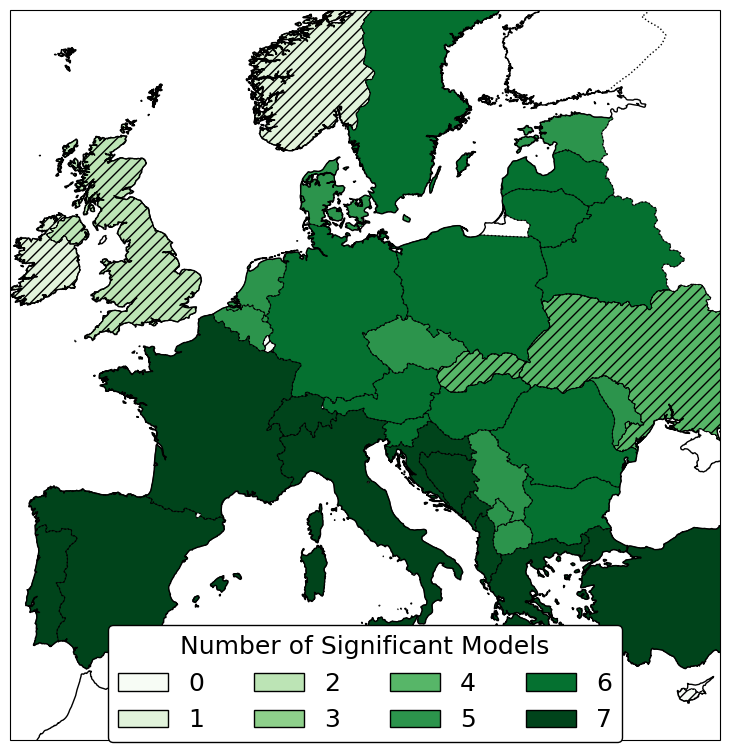

In [2]:
import os
import pandas as pd
import pycountry
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import math

# 1) Region codes (ISO-A2)
EU27 = [
    'AT','BE','BG','HR','CZ','DK','EE','FR','DE','GR',
    'HU','IE','IT','LV','LT','LU','MT','NL','PL','PT','RO',
    'SK','SI','ES','SE','CY'
]
extras = ['GB','NO','BA','ME','RS','AL','MK','CH','IS','TR','UA','BY','MD','XK']
region_codes = EU27 + extras

# 2) Load your country-level t-test CSV
csv_path = os.path.join(
    "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power",
    "country_drought_stats_BOC_vs_EOC.csv"
)
df = pd.read_csv(csv_path)

# 3) Map ISO-3 → ISO-2
def iso3_to_iso2(iso3):
    if iso3 == 'KOS': return 'XK'
    c = pycountry.countries.get(alpha_3=iso3)
    return c.alpha_2 if c else None

df['ISO_A2'] = df['country'].map(iso3_to_iso2)
df = df.dropna(subset=['ISO_A2'])

# 4) Count significant models per country
counts = (
    df[df['significant']]
      .groupby('ISO_A2')
      .size()
      .reset_index(name='n_models_significant')
)

# 5) Build summary with zeros for missing
summary = pd.DataFrame({'ISO_A2': region_codes})
summary = summary.merge(counts, on='ISO_A2', how='left')
summary['n_models_significant'] = summary['n_models_significant'].fillna(0).astype(int)

# 6) Load Natural Earth & fix ISO_A2
ne50 = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).to_crs("EPSG:4326")
world.loc[world.NAME_LONG=='France',             'ISO_A2'] = 'FR'
world.loc[world.NAME_LONG=='Russian Federation', 'ISO_A2'] = 'RU'
world.loc[world.NAME_LONG=='United Kingdom',     'ISO_A2'] = 'GB'
world.loc[world.NAME_LONG=='Norway',             'ISO_A2'] = 'NO'
world.loc[world.NAME_LONG.str.contains('Kosovo', na=False), 'ISO_A2'] = 'XK'

# 7) Filter & merge
eu = world[world.ISO_A2.isin(region_codes)][['ISO_A2','geometry']].copy()
eu = eu.merge(summary, on='ISO_A2', how='left')
eu['n_models_significant'] = eu['n_models_significant'].fillna(0).astype(int)

# force RU & FI to NaN
eu.loc[eu.ISO_A2=='RU', 'n_models_significant'] = np.nan
eu.loc[eu.ISO_A2=='FI', 'n_models_significant'] = np.nan

# dissolve in case of multipart
eu = eu.dissolve(by='ISO_A2', aggfunc='max').reset_index()

# 8) Build discrete colormap
max_models = int(eu['n_models_significant'].max(skipna=True))
cmap = plt.get_cmap('Greens', max_models+1)

# 9) Plot
fig, ax = plt.subplots(
    figsize=(12,8),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
ax.set_extent([-10.5, 35, 33, 64], crs=ccrs.PlateCarree())

eu.plot(
    column='n_models_significant',
    cmap=cmap,
    linewidth=0.5,
    edgecolor='black',
    ax=ax,
    legend=False,
    missing_kwds={'color':'white'}
)

low = eu[eu['n_models_significant'] < 5]
low.plot(
    ax=ax,
    facecolor='none',
    edgecolor='black',
    hatch='///',
    linewidth=0.5,
    zorder=3
)

ax.coastlines('10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
# ensure correct aspect
lat0 = (33 + 64) / 2.0
ax.set_aspect(1.0/np.cos(np.deg2rad(lat0)))

# 10) Bottom‐center two‐row legend
patches = [
    mpatches.Patch(
        facecolor=cmap(i),
        edgecolor='black',
        label=f"{i}"
    )
    for i in range(max_models+1)
]
n_items = max_models+1
ncols = math.ceil(n_items/2)

leg = ax.legend(
    handles=patches,
    title='Number of Significant Models',
    loc='lower center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=ncols,
    fontsize=18,
    title_fontsize=18,
    frameon=True,
    edgecolor='black'
)
leg.get_frame().set_alpha(1)

plt.tight_layout(rect=[0,0.05,1,1])
#plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/agreement_drought_days_yearly.pdf", bbox_inches='tight', dpi=300)
plt.show()


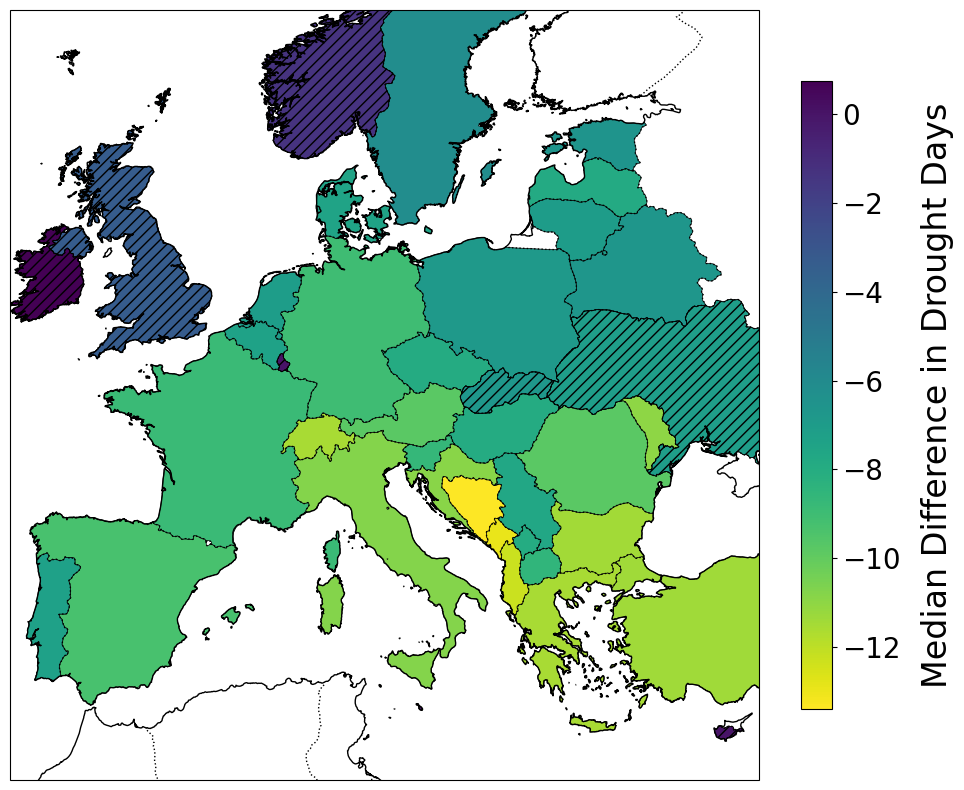

In [4]:
import os
import pandas as pd
import pycountry
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap

# ─── 1) Load your raw per‐model results ───────────────────────────────
df = pd.read_csv(
    "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/"
    "power/country_drought_stats_BOC_vs_EOC.csv"
)
# columns: model, country (ISO3), mean_boc, mean_eoc, shapiro_boc, shapiro_eoc, ttest_p, significant

# ─── 2) Map ISO3 → ISO2 (explicit KOS → XK) ───────────────────────────
def iso3_to_iso2(iso3):
    if iso3 == 'KOS':          return 'XK'
    if iso3 == 'MKD':          return 'MK'  # North Macedonia
    try:
        return pycountry.countries.get(alpha_3=iso3).alpha_2
    except:
        return None

df['ISO_A2'] = df['country'].map(iso3_to_iso2)
df = df.dropna(subset=['ISO_A2'])

# ─── 3) Build per‐country summary ─────────────────────────────────────
# a) count how many models were significant
counts = (
    df[df['significant']]
      .groupby('ISO_A2')
      .size()
      .rename('n_models_significant')
)

# b) compute each country’s median difference in annual drought days
diffs = (
    df.assign(diff = df['mean_eoc'] - df['mean_boc'])
      .groupby('ISO_A2')['diff']
      .median()
      .rename('median_drought_diff')
)

# c) assemble into one DataFrame
summary = pd.concat([counts, diffs], axis=1).fillna(0).reset_index()

# ─── 4) Define region codes ──────────────────────────────────────────
EU27 = [
    'AT','BE','BG','HR','CZ','DK','EE','FR','DE','GR',
    'HU','IE','IT','LV','LT','LU','MT','NL','PL','PT','RO',
    'SK','SI','ES','SE','CY'
]
extras = ['GB','NO','BA','ME','RS','AL','MK','CH','IS','TR','UA','BY','MD','XK']
region_codes = EU27 + extras

# ─── 5) Load Natural Earth & fix ISO_A2 ──────────────────────────────
ne50  = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).to_crs("EPSG:4326")
world.loc[world.NAME_LONG=='France',             'ISO_A2'] = 'FR'
world.loc[world.NAME_LONG=='Russian Federation', 'ISO_A2'] = 'RU'
world.loc[world.NAME_LONG=='United Kingdom',     'ISO_A2'] = 'GB'
world.loc[world.NAME_LONG=='Norway',             'ISO_A2'] = 'NO'
world.loc[world.NAME_LONG.str.contains('Kosov'), 'ISO_A2'] = 'XK'

eu = world[world['ISO_A2'].isin(region_codes)][['ISO_A2','geometry']].copy()

# ─── 6) Merge in our summary ─────────────────────────────────────────
eu = eu.merge(summary, on='ISO_A2', how='left')
eu['n_models_significant']   = eu['n_models_significant'].fillna(0).astype(int)
eu['median_drought_diff']    = eu['median_drought_diff'].fillna(0.0)

# dissolve multi-part countries using max for count & first for diff
eu = (
    eu.dissolve(
        by='ISO_A2',
        aggfunc={'n_models_significant':'max','median_drought_diff':'first'}
    )
    .reset_index()
)

# ─── 7) Colormap setup ───────────────────────────────────────────────
vmin, vmax = eu['median_drought_diff'].min(), eu['median_drought_diff'].max()
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

base = plt.get_cmap('Blues')
colors = base(np.linspace(0,1,256))
light = (1 - 0.2)*colors + 0.2
#cmap = LinearSegmentedColormap.from_list('LightReds', light)
cmap = plt.get_cmap("viridis_r")

# ─── 8) Plot ────────────────────────────────────────────────────────
fig, ax = plt.subplots(
    figsize=(12,8),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
#ax.set_extent([-12,35,33,64], ccrs.PlateCarree())

eu.plot(
    column='median_drought_diff',
    cmap=cmap, norm=norm,
    linewidth=0.5, edgecolor='black',
    ax=ax, missing_kwds={'color':'lightgrey'},
    legend=False
)

# hatch countries with fewer than 5 models agreeing
low = eu[eu['n_models_significant'] < 5]
low.plot(
    facecolor='none',
    edgecolor='black',
    hatch='///',
    linewidth=0.5,
    ax=ax, zorder=3
)
ax.set_aspect('auto')

ax.set_extent([-10.5, 35, 33, 64], crs=ccrs.PlateCarree())
ax.coastlines('10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.tick_params(axis='y', labelsize=24)

lat0 = (33 + 64) / 2.0
ax.set_aspect(1.0 / np.cos(np.deg2rad(lat0)))

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label('Median Difference in Drought Days', rotation=90, labelpad=15, fontsize=24)
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()
plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/difference_drought_days_yearly.pdf", bbox_inches='tight', dpi=300)
plt.show()


In [49]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from cartopy.io.shapereader import natural_earth
from scipy.stats import shapiro, ttest_ind

# 1) Natural Earth → Europe+Turkey+Kosovo (iso_a3)
shp    = natural_earth('110m','cultural','admin_0_countries')
world  = gpd.read_file(shp).set_crs("EPSG:4326")
europe = world[
    (world.CONTINENT=='Europe') | (world.ADM0_A3.isin(['TUR','RKS']))
][['ADM0_A3','geometry']].rename(columns={'ADM0_A3':'iso_a3'})

# 2) Settings
power_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power"
models    = ["ACCESS-CM2","CanESM5","CMCC-CM2-SR5","CMCC-ESM2",
             "HadGEM3-GC31-LL","HadGEM3-GC31-MM","MRI-ESM2-0"]
periods   = {"BOC":"historical","EOC":"ssp585"}
seasons   = ["Winter","Spring","Summer","Autumn"]

results = []

for model in models:
    # locate your two CSVs
    paths = {}
    for code, sub in periods.items():
        p = os.path.join(power_dir, f"{model}_1x1grid", sub,
                         f"solar_drought_events_{code}.csv")
        if os.path.isfile(p):
            paths[code] = p
    if set(paths)!=set(periods):
        print(f" ⚠️ skipping {model}, missing period CSV")
        continue

    # load both into DataFrames (including season col)
    df_boc = pd.read_csv(paths['BOC'])
    df_eoc = pd.read_csv(paths['EOC'])

    # build unified grid → cell→country map (as before)
    lats = np.sort(np.unique(np.concatenate([df_boc.lat, df_eoc.lat])))
    lons = np.sort(np.unique(np.concatenate([df_boc.lon, df_eoc.lon])))
    dlat, dlon = np.median(np.diff(lats)), np.median(np.diff(lons))

    cells = []
    for lat in lats:
        for lon in lons:
            cells.append({
                'lat':lat,'lon':lon,
                'geometry':box(lon-dlon/2,lat-dlat/2,
                              lon+dlon/2,lat+dlat/2)
            })
    cells_gdf   = gpd.GeoDataFrame(cells, crs="EPSG:4326")
    cells_eq    = cells_gdf.to_crs("EPSG:3035")
    europe_eq   = europe.to_crs("EPSG:3035")
    inter       = gpd.overlay(cells_eq, europe_eq, how='intersection')
    inter['area']= inter.geometry.area
    idx         = inter.groupby(['lat','lon'])['area'].idxmax()
    mapping     = inter.loc[idx, ['lat','lon','iso_a3']]
    cell2country = { (r.lat,r.lon):r.iso_a3 for _,r in mapping.iterrows() }

    # now loop seasons
    for season in seasons:
        # 3) for BOC and EOC, sum durations per cell×year×season
        ts = {}
        for code, df in [('BOC',df_boc),('EOC',df_eoc)]:
            # filter rows of that season
            dfx = df[df.season==season]
            # sum drought days per cell-year
            cy = (
                dfx.groupby(['lat','lon','year'])['duration']
                   .sum()
                   .reset_index(name='drought_days')
            )
            # map to iso_a3
            cy['iso_a3'] = cy.apply(
                lambda r: cell2country.get((r.lat,r.lon),np.nan),
                axis=1
            )
            cy = cy.dropna(subset=['iso_a3'])
            # average across all cells in each country-year
            cty = (
                cy.groupby(['iso_a3','year'])['drought_days']
                   .mean()
                   .reset_index(name='drought_days')
            )
            ts[code] = cty

        # 4) Shapiro + t-test per country for this season
        boc_df = ts['BOC']
        eoc_df = ts['EOC']
        common = set(boc_df.iso_a3) & set(eoc_df.iso_a3)
        for iso in common:
            x = boc_df.loc[boc_df.iso_a3==iso, 'drought_days'].values
            y = eoc_df.loc[eoc_df.iso_a3==iso, 'drought_days'].values

            # 1) require at least 3 years with real data
            if len(x) < 3 or len(y) < 3:
                continue

            # 2) if either period is completely flat → skip
            if np.allclose(x, x[0]) or np.allclose(y, y[0]):
                results.append({
                    'model':       model,
                    'country':     iso,
                    'season':      season,
                    'mean_boc':    np.nan,
                    'mean_eoc':    np.nan,
                    'shapiro_boc_p': np.nan,
                    'shapiro_eoc_p': np.nan,
                    'ttest_p':     np.nan,
                    'significant': False,
                    'note':        'flat_series'
                })
                continue

            # 3) now safe to test
            p1 = shapiro(x).pvalue
            p2 = shapiro(y).pvalue
            tstat, p_t = ttest_ind(x, y, equal_var=False)

            results.append({
                'model':        model,
                'country':      iso,
                'season':       season,
                'mean_boc':     x.mean(),
                'mean_eoc':     y.mean(),
                'shapiro_boc_p':p1,
                'shapiro_eoc_p':p2,
                'ttest_p':      p_t,
                'significant':  (p_t < 0.05),
                'note':         ''
            })

# 5) save
out = pd.DataFrame(results)
out.to_csv(os.path.join(power_dir,"country_seasonal_drought_tests.csv"),
           index=False)
print("✅ Seasonal country‐level tests written.")


✅ Seasonal country‐level tests written.


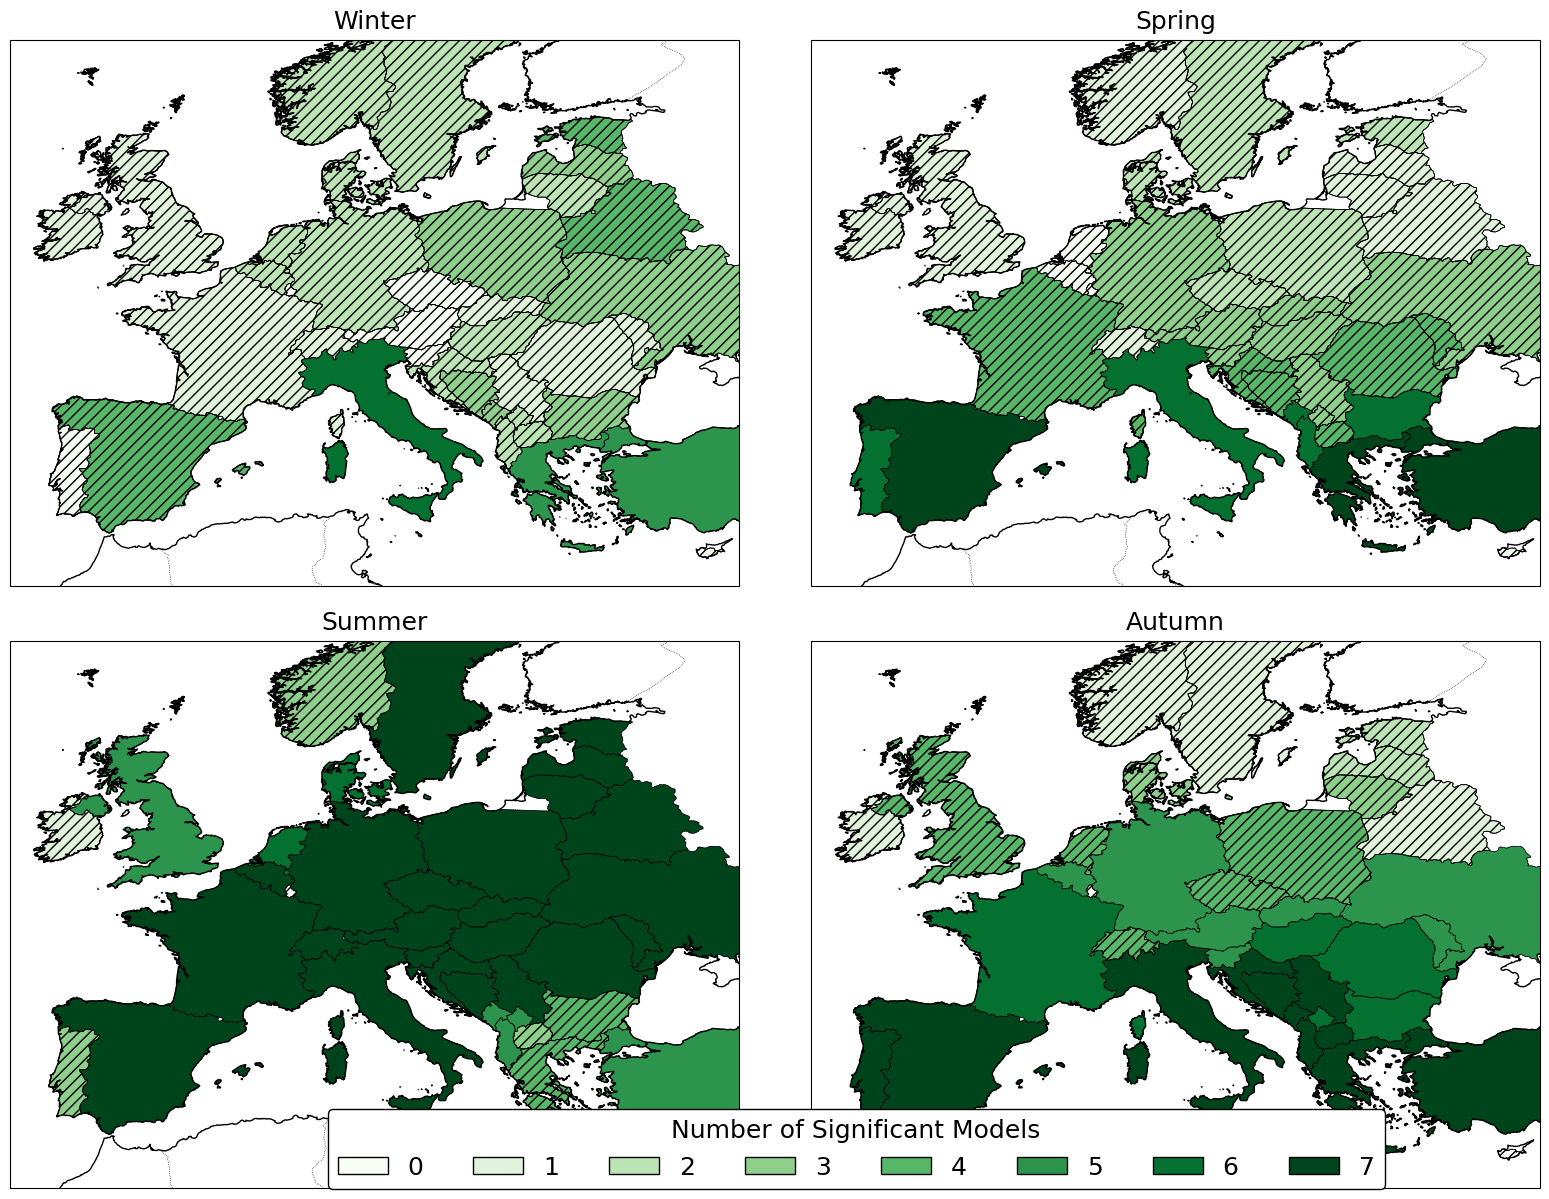

In [24]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import pycountry

# ─── 1) Load your raw seasonal t-test results ─────────────────────────
# This CSV must have columns: model, country (ISO3), season, significant (bool)
csv_path = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/country_seasonal_drought_tests.csv"
df = pd.read_csv(csv_path)

# ─── 2) Map ISO-3 → ISO-2 (incl. KOS→XK, MKD→MK) ──────────────────────
def iso3_to_iso2(iso3):
    if iso3 == 'KOS': return 'XK'
    if iso3 == 'MKD': return 'MK'
    try:
        return pycountry.countries.get(alpha_3=iso3).alpha_2
    except:
        return None

df['ISO_A2'] = df['country'].map(iso3_to_iso2)
df = df.dropna(subset=['ISO_A2'])

# ─── 3) Build per‐country×season summary of “# significant models” ─────
# Count one row per model, so grouping by ISO_A2+season and counting unique models
summary = (
    df[df['significant']]
      .groupby(['ISO_A2','season'])['model']
      .nunique()
      .reset_index(name='n_models_significant')
)

# Ensure every (country,season) appears, even if zero
seasons = ['Winter','Spring','Summer','Autumn']
# Your full list of ISO_A2 codes
EU27   = ['AT','BE','BG','HR','CZ','DK','EE','FR','DE','GR',
          'HU','IE','IT','LV','LT','LU','MT','NL','PL','PT','RO',
          'SK','SI','ES','SE','CY']
extras = ['GB','NO','BA','ME','RS','AL','MK','CH','IS','TR','UA','BY','MD','XK']
all_codes = EU27 + extras

# Cartesian product to fill zeros
full = pd.MultiIndex.from_product([all_codes, seasons], names=['ISO_A2','season'])
summary = summary.set_index(['ISO_A2','season']).reindex(full, fill_value=0).reset_index()

# ─── 4) Load Natural Earth & force-map ISO_A2 ─────────────────────────
ne50  = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).to_crs("EPSG:4326")
world.loc[world.NAME_LONG=='France',             'ISO_A2'] = 'FR'
world.loc[world.NAME_LONG=='Russian Federation', 'ISO_A2'] = 'RU'
world.loc[world.NAME_LONG=='United Kingdom',     'ISO_A2'] = 'GB'
world.loc[world.NAME_LONG=='Norway',             'ISO_A2'] = 'NO'
world.loc[world.NAME_LONG.str.contains('Kosov'), 'ISO_A2'] = 'XK'

eu = world[world['ISO_A2'].isin(all_codes)][['ISO_A2','geometry']].copy()

# ─── 5) Prepare colormap ─────────────────────────────────────────────
maxm = summary['n_models_significant'].max()  # ≤ number of models (7)
cmap = plt.get_cmap('Greens', maxm+1)
norm = mpl.colors.BoundaryNorm(np.arange(maxm+2)-0.5, maxm+1)

# ─── 6) Build 2×2 map ────────────────────────────────────────────────
fig, axes = plt.subplots(
    2, 2, figsize=(18,14),
    subplot_kw={'projection': ccrs.PlateCarree()},
    constrained_layout=False
)

for ax, season in zip(axes.flat, seasons):
    # merge this season’s counts into eu GeoDataFrame
    df_seas = summary[summary['season']==season][['ISO_A2','n_models_significant']]
    gdf = eu.merge(df_seas, on='ISO_A2', how='left')
    gdf['n_models_significant'] = gdf['n_models_significant'].fillna(0).astype(int)

    # main choropleth
    gdf.plot(
        column='n_models_significant',
        cmap=cmap, norm=norm,
        linewidth=0.5, edgecolor='black',
        ax=ax,
        missing_kwds={'color':'lightgrey'}
    )

    # hatch if fewer than 5 models agree
    low = gdf[gdf['n_models_significant'] < 5]
    low.plot(
        facecolor='none', edgecolor='black',
        hatch='///', linewidth=0.5,
        ax=ax, zorder=3
    )

    ax.coastlines('10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_extent([-12,35,33,64], crs=ccrs.PlateCarree())
    ax.set_aspect('auto')
    ax.set_title(season, fontsize=18, pad=8)

# ─── 7) Layout, title & legend ───────────────────────────────────────
fig.subplots_adjust(
    left=0.03, right=0.88,
    top=0.90, bottom=0.08,
    wspace=0.10, hspace=0.10
)

patches = [
    mpatches.Patch(color=cmap(i), label=f"{i} ")
    for i in range(maxm+1)
]
patches = [
    mpatches.Patch(
        facecolor=cmap(i), edgecolor='black',
        label=f"{i}"
        # Model{'s' if i!=1 else ''}
    ) for i in range(maxm+1)
]
fig.legend(
    handles=patches,
    title="Number of Significant Models",
    loc='lower center', ncol=8,
    fontsize=18, title_fontsize=18,
    frameon=True, edgecolor='black',
    bbox_to_anchor=(0.5, 0.07), framealpha = 1
)
plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/drought_days_seasonal_agreement.pdf", bbox_inches='tight', dpi=300)
plt.show()


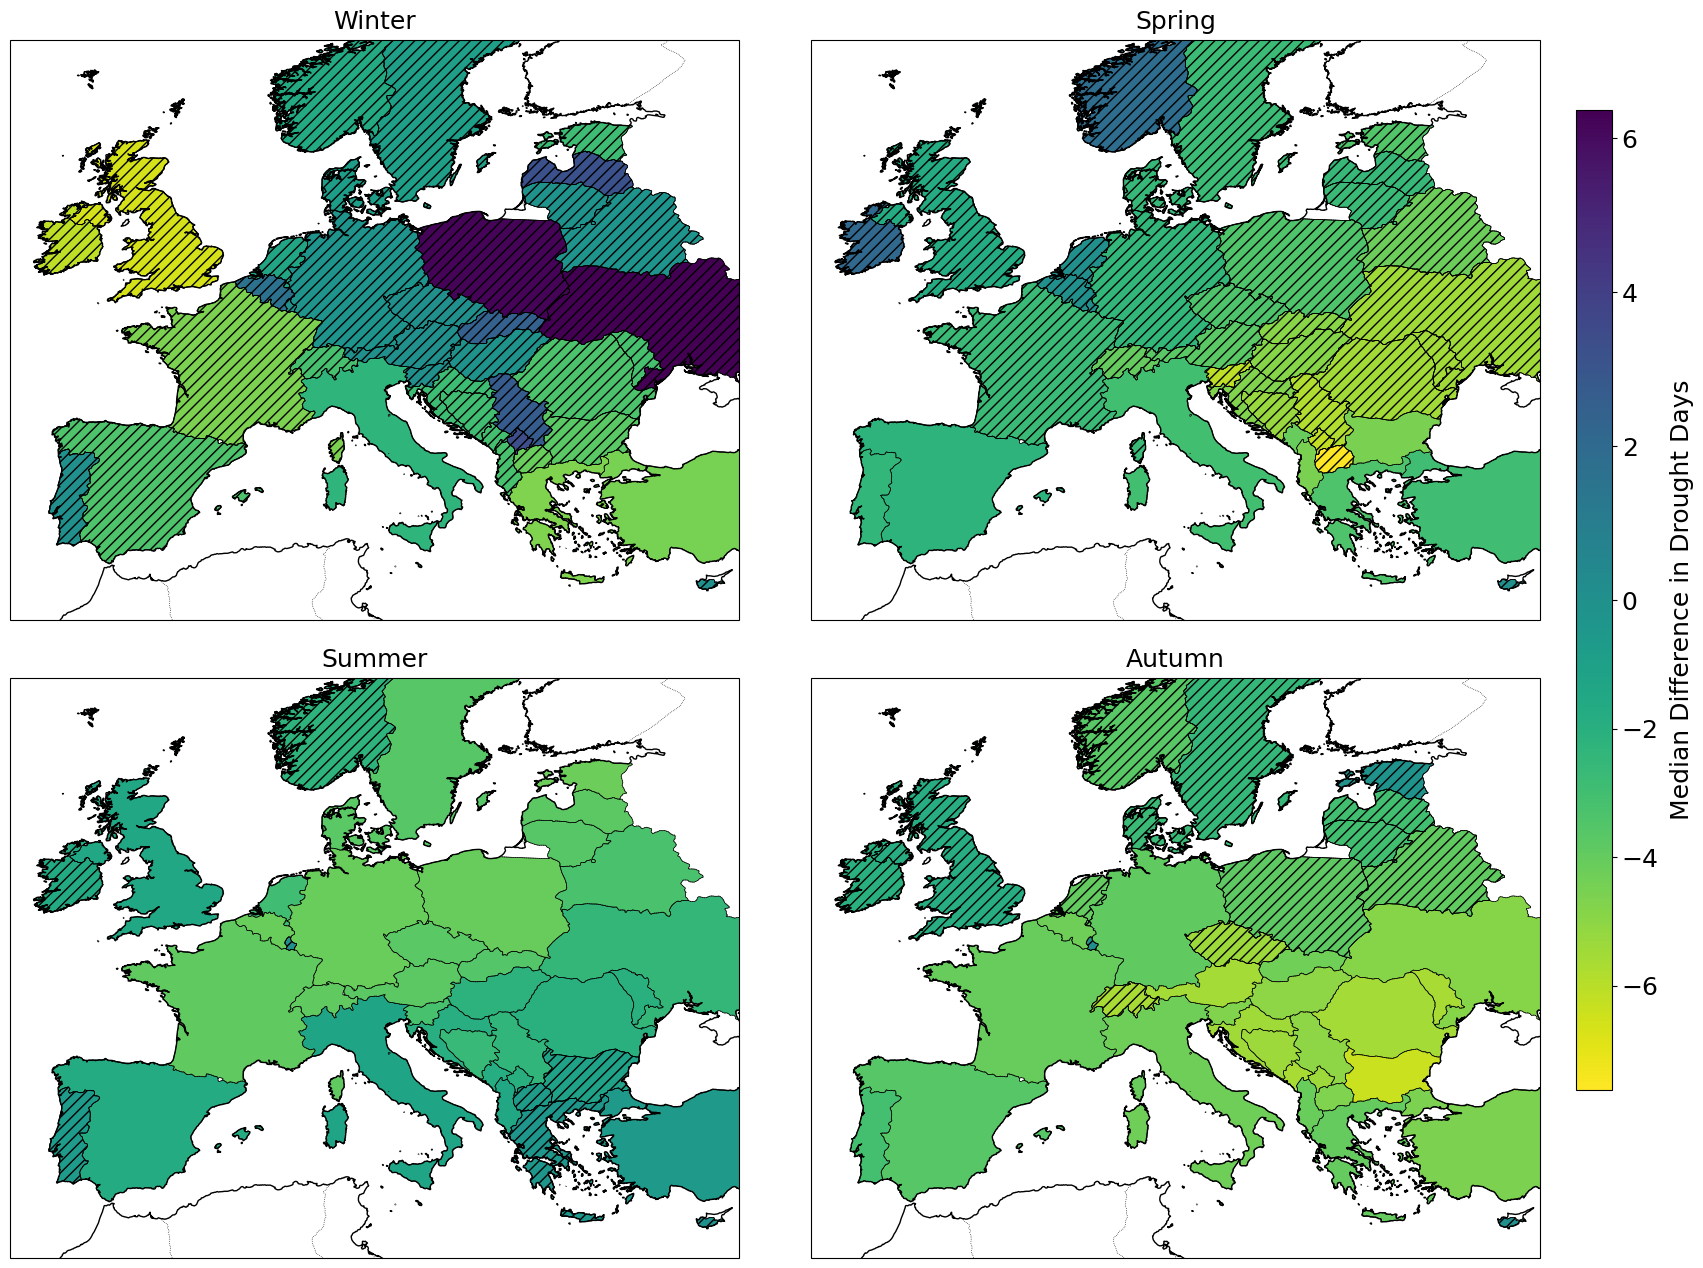

In [25]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import pycountry

# ─── 1) Load your raw seasonal t-test CSV ─────────────────────────────
csv_path = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/" \
           "power/country_seasonal_drought_tests.csv"
df = pd.read_csv(csv_path)
# expected columns: model, country (ISO3), season, mean_boc, mean_eoc, significant

# ─── 2) Map ISO-3 → ISO-2 (incl. KOS→XK, MKD→MK) ──────────────────────
def iso3_to_iso2(iso3):
    if iso3 == 'KOS': return 'XK'
    if iso3 == 'MKD': return 'MK'
    try:
        return pycountry.countries.get(alpha_3=iso3).alpha_2
    except:
        return None

df['ISO_A2'] = df['country'].map(iso3_to_iso2)
df = df.dropna(subset=['ISO_A2'])

# ─── 3) Compute per‐country×season metrics ────────────────────────────
# filter only those models flagged significant
sig = df[df['significant']]

# count significant models
counts = (
    sig.groupby(['ISO_A2','season'])['model']
       .nunique()
       .rename('n_models_significant')
)

# median drought‐day difference among significant models
diffs = (
    sig.assign(diff = sig['mean_eoc'] - sig['mean_boc'])
       .groupby(['ISO_A2','season'])['diff']
       .median()
       .rename('median_drought_diff')
)

# combine into one DataFrame, then reindex full grid of country×season
seasons = ['Winter','Spring','Summer','Autumn']
# your full ISO_A2 list
EU27   = ['AT','BE','BG','HR','CZ','DK','EE','FR','DE','GR',
          'HU','IE','IT','LV','LT','LU','MT','NL','PL','PT','RO',
          'SK','SI','ES','SE','CY']
extras = ['GB','NO','BA','ME','RS','AL','MK','CH','IS','TR','UA','BY','MD','XK']
all_codes = EU27 + extras

idx = pd.MultiIndex.from_product([all_codes, seasons],
                                 names=['ISO_A2','season'])
summary = pd.concat([counts, diffs], axis=1).reindex(idx).fillna(0).reset_index()

# ─── 4) Load Natural Earth & force‐map ISO_A2 ─────────────────────────
ne50  = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).to_crs("EPSG:4326")

# force‐map a few
world.loc[world.NAME_LONG=='France',             'ISO_A2'] = 'FR'
world.loc[world.NAME_LONG=='Russian Federation', 'ISO_A2'] = 'RU'
world.loc[world.NAME_LONG=='United Kingdom',     'ISO_A2'] = 'GB'
world.loc[world.NAME_LONG=='Norway',             'ISO_A2'] = 'NO'
world.loc[world.NAME_LONG.str.contains('Kosov'), 'ISO_A2'] = 'XK'

eu_base = world[world.ISO_A2.isin(all_codes)][['ISO_A2','geometry']].copy()

# ─── 5) Prepare colormap (5–95% clip) ────────────────────────────────
vmin = summary['median_drought_diff'].quantile(0)
vmax = summary['median_drought_diff'].quantile(1)
norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

base = plt.get_cmap('RdBu_r', 256)
colors = base(np.linspace(0,1,256))
# blend the top half (warm end) 50% with white
for i in range(128,256):
    colors[i] = 0.5*colors[i] + 0.5*np.array([1,1,1,1])
#light_cmap = LinearSegmentedColormap.from_list("LightRdBu", colors)
cmap="viridis_r"  # or use 'RdBu_r' for a more standard colormap

# ─── 6) Plot 2×2 seasonal panel ──────────────────────────────────────
fig, axes = plt.subplots(
    2, 2, figsize=(18,14),
    subplot_kw={'projection': ccrs.PlateCarree()},
    constrained_layout=False
)

for ax, season in zip(axes.flat, seasons):
    df_seas = summary[summary['season']==season]
    gdf = eu_base.merge(
        df_seas[['ISO_A2','n_models_significant','median_drought_diff']],
        on='ISO_A2', how='left'
    )
    gdf['n_models_significant']   = gdf['n_models_significant'].fillna(0).astype(int)
    gdf['median_drought_diff']    = gdf['median_drought_diff'].fillna(0.0)

    # fill by diff
    gdf.plot(
        column='median_drought_diff',
        cmap=cmap, norm=norm,
        linewidth=0.5, edgecolor='black',
        ax=ax, legend=False,
        missing_kwds={'color':'lightgrey'}
    )
    # hatch <5 agreeing models
    low = gdf[gdf['n_models_significant'] < 5]
    low.plot(
        facecolor='none', edgecolor='black',
        hatch='///', linewidth=0.5,
        ax=ax, zorder=3
    )

    ax.coastlines('10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_extent([-12,35,33,64], crs=ccrs.PlateCarree())
    ax.set_title(season, fontsize=18, pad=8)
    ax.set_aspect('auto')

fig.subplots_adjust(
    left=0.03, right=0.88,
    top=0.90, bottom=0.03,
    wspace=0.1, hspace=0.1
)


# shared colorbar
cax = fig.add_axes([0.90,0.15,0.02,0.7])
sm  = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A=[]
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Median Difference in Drought Days', fontsize=18, labelpad=8)
cbar.ax.tick_params(labelsize=18)
plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/drought_days_seasonal_change.pdf", bbox_inches='tight', dpi=300)
plt.show()
